Title: Portät König Maximilian II. von Bayern

Depicts: [Maximilian II of Bavaria](http://www.wikidata.org/entity/Q44530)

Year: 1860

Creator: Franz Seraph von Stirnbrand

Copyright: public domain

Wikidata link: [http://www.wikidata.org/entity/Q119228942](http://www.wikidata.org/entity/Q119228942)



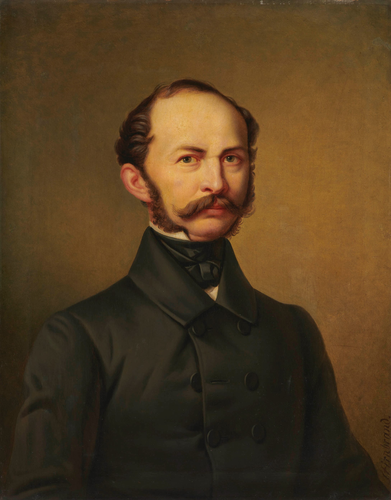





Title: Porträt Königin Pauline von Württemberg

Depicts: [Pauline Therese of Württemberg](http://www.wikidata.org/entity/Q234703)

Year: 1822

Creator: Franz Seraph von Stirnbrand

Copyright: public domain

Wikidata link: [http://www.wikidata.org/entity/Q119230131](http://www.wikidata.org/entity/Q119230131)



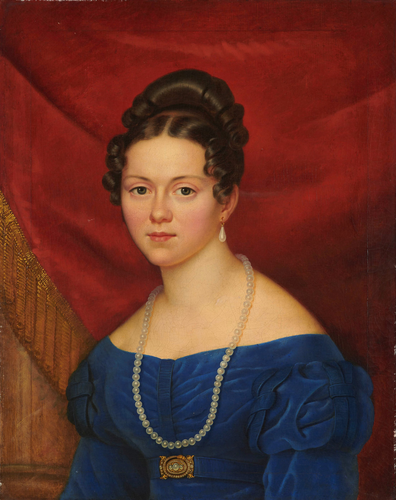





Title: Porträt Emilie Kuhn

Depicts: [Emilie Kuhn](http://www.wikidata.org/entity/Q16467572)

Year: 1842

Creator: Franz Seraph von Stirnbrand

Copyright: public domain

Wikidata link: [http://www.wikidata.org/entity/Q119230133](http://www.wikidata.org/entity/Q119230133)



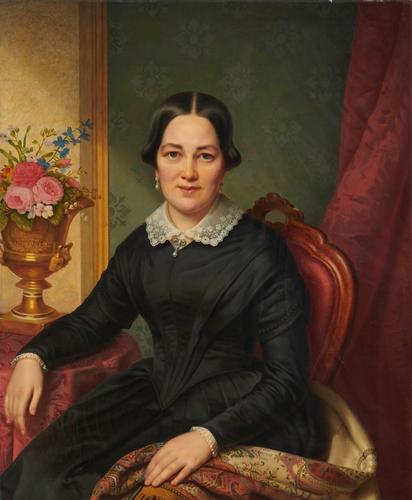





Title: Porträt Emilie Kuhn

Depicts: [Emilie Kuhn](http://www.wikidata.org/entity/Q16467572)

Year: 1849

Creator: Franz Seraph von Stirnbrand

Copyright: public domain

Wikidata link: [http://www.wikidata.org/entity/Q119230135](http://www.wikidata.org/entity/Q119230135)



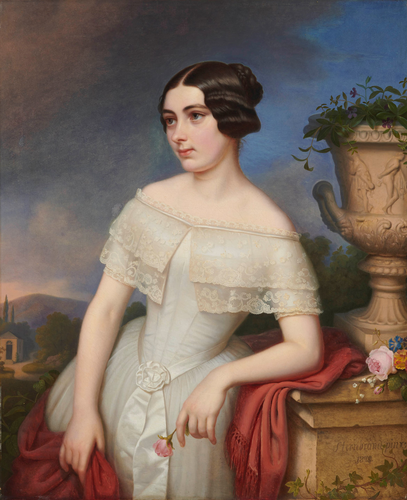





Title: Porträt König Wilhelm I. von Württemberg

Depicts: [Wilhelm I of Württemberg](http://www.wikidata.org/entity/Q170398)

Year: 1859

Creator: Franz Seraph von Stirnbrand

Copyright: public domain

Wikidata link: [http://www.wikidata.org/entity/Q119230137](http://www.wikidata.org/entity/Q119230137)



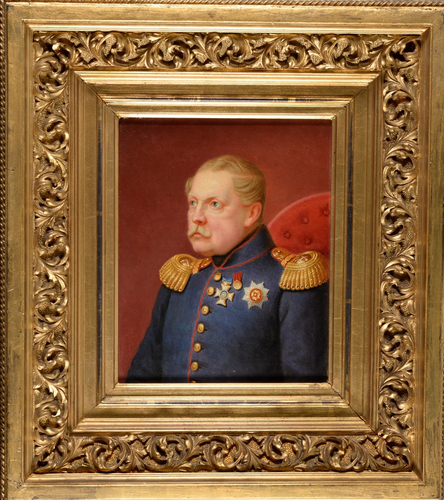





Title: Porträt König Wilhelm I. von Württemberg

Depicts: [Wilhelm I of Württemberg](http://www.wikidata.org/entity/Q170398)

Year: 1841

Creator: Franz Seraph von Stirnbrand

Copyright: public domain

Wikidata link: [http://www.wikidata.org/entity/Q119230139](http://www.wikidata.org/entity/Q119230139)



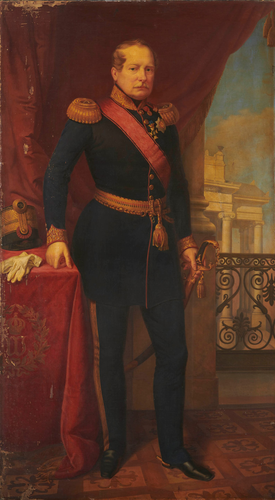

In [26]:
from SPARQLWrapper import SPARQLWrapper, JSON
from PIL import Image
import requests

# VARIABLES

sparql_endpoint_url = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql'
wikibase_url = 'https://www.wikidata.org'
api_url = '/w/api.php'

# Wikidata requires a user agent header to prevent spam requests
user_agent = 'Ex_Books_conference_bot/0.0 (https://github.com/SimonXIX/Experimental_Books_workshop; ad7588@coventry.ac.uk)'

# SPARQL query
# see in Wikidata's Query Service GUI at:
# https://query.wikidata.org/#SELECT%20%3Fitem%20WHERE%20%7B%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20"%5BAUTO_LANGUAGE%5D%2Cen".%20%7D%0A%20%20%0A%20%20%3Fitem%20wdt%3AP31%20wd%3AQ3305213.%0A%7D%0ALIMIT%2010
query = """
#defaultView:ImageGrid
SELECT ?instance_of ?instance_ofLabel ?creatorLabel ?inception ?copyright_status ?copyright_statusLabel ?image ?depicts ?depictsLabel WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  ?instance_of wdt:P31 wd:Q134307;
    wdt:P170 wd:Q119228937, ?creator.
  OPTIONAL { ?instance_of wdt:P571 ?inception. }
  OPTIONAL { ?instance_of wdt:P6216 ?copyright_status. }
  OPTIONAL { ?instance_of wdt:P18 ?image. }
  OPTIONAL { ?instance_of wdt:P180 ?depicts. }
}
LIMIT 100
"""

# SUBROUTINES

def get_delay(date):
    try:
        date = datetime.datetime.strptime(date, '%a, %d %b %Y %H:%M:%S GMT')
        timeout = int((date - datetime.datetime.now()).total_seconds())
    except ValueError:
        timeout = int(date)
    return timeout

def get_image(url, headers):
    r = requests.get(url, headers=headers, stream=True)
    if r.status_code == 200:
        im = Image.open(r.raw)
        return im
    if r.status_code == 500:
        return None
    if r.status_code == 403:
        return None
    if r.status_code == 429:
        timeout = get_delay(r.headers['retry-after'])
        print('Timeout {} m {} s'.format(timeout // 60, timeout % 60))
        time.sleep(timeout)
        get_image(url, headers)

# MAIN PROGRAM

# create SPARQL query
sparql = SPARQLWrapper(sparql_endpoint_url, agent=user_agent)

# retrieve results and convert to JSON format
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
result = sparql.query().convert()

# for each result, print various data fields
for item in result['results']['bindings']:
    year = item['inception']['value']
    
    print('Title: ' + item['instance_ofLabel']['value'] + '\n')
    print('Depicts: ' + '[' + item['depictsLabel']['value'] + '](' + item['depicts']['value'] + ')' + '\n')
    print('Year: ' + year[0:4] + '\n')
    print('Creator: ' + item['creatorLabel']['value'] + '\n')
    print('Copyright: ' + item['copyright_statusLabel']['value'] + '\n')
    print('Wikidata link: ' + '[' + item['instance_of']['value'] + ']' + '(' + item['instance_of']['value'] + ')' + '\n')

    # get image from image URL and display resized version
    image_url=item['image']['value']
    headers = {'User-Agent': 'Ex_Books_conference_bot/0.0 (https://github.com/SimonXIX/Experimental_Books_workshop; ad7588@coventry.ac.uk)'}
    im = get_image(image_url, headers)
    im.thumbnail((500, 500), Image.Resampling.LANCZOS)
    display(im)
    print('\n\n\n')